# Setup

In [1]:
import io
import base64
import sys
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import plotly as plty
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
# import h5py
import scipy as sp
import pandas as pd
# import sklearn as sk 
import cupy as cp
import cupyx.scipy as cps
from cupyx.scipy.sparse.linalg import spsolve

%reload_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

# FEM 1D: $\frac{d^2u}{dx^2} = -f(x)$

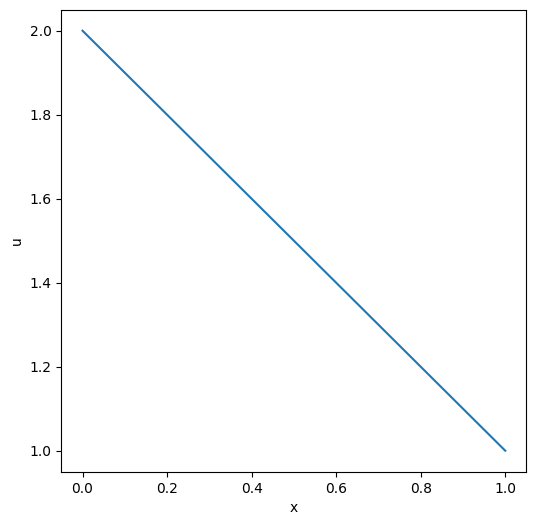

Used: 807.35 MB
Total allocated: 1160.52 MB


In [28]:
# fem 1d code
def fem1d(a, plot=False): # a = any numpy (cpu) or cupy (gpu) array

    mod = cp.get_array_module(a)
    if mod is np:
        # print('Using cpu')
        mod_scipy = sp
    elif mod is cp:
        # print('Using gpu')
        mod_scipy = cps
        # Memory Pools for Efficient Allocation
        mp = cp.get_default_memory_pool()
        pp = cp.get_default_pinned_memory_pool()
        
    n = 100
    x = mod.linspace(0, 1, n)
    dx = x[1:] - x[:-1]
    
    # field u
    u = mod.zeros_like(x)
    u[0] = 2
    u[-1] = 1
    
    # rhs b
    b = mod.zeros_like(x[1:-1])
    b[0] = (u[0]/dx[0])
    b[1:-1] = 0
    b[-1] = (u[-1]/dx[n-2])
    
    # source f
    # b[45:55] = 1

    # row and column for A matrix
    row = mod.array([], dtype=mod.int32)
    col = mod.array([], dtype=mod.int32)
    As  = mod.array([])
    
    # i=1 boundary condition
    # A[0, 0] = (1/dx[0]) + (1/dx[1])
    row = mod.append(row, 0)
    col = mod.append(col, 0)
    As  = mod.append(As, (1/dx[0]) + (1/dx[1]))

    # A[0, 1] = - (1/dx[1])
    row = mod.append(row, 0)
    col = mod.append(col, 1)
    As  = mod.append(As, - (1/dx[1]))
    
    # i=2...n-3
    
    for i in range(2, n-2):
        
        # A[i-1, i-2] = - (1/dx[i-1])
        row = mod.append(row, i-1)
        col = mod.append(col, i-2)
        As  = mod.append(As, - (1/dx[i-1]))
        
        # A[i-1, i-1] = (1/dx[i-1]) + (1/dx[i])
        row = mod.append(row, i-1)
        col = mod.append(col, i-1)
        As  = mod.append(As, (1/dx[i-1]) + (1/dx[i]))
        
        # A[i-1, i]   = - (1/dx[i])
        row = mod.append(row, i-1)
        col = mod.append(col, i)
        As  = mod.append(As, - (1/dx[i]))
    
    # i=n-2 boundary condition
    # A[-1, -2] = - (1/dx[n-3])
    row = mod.append(row, n-2-1)
    col = mod.append(col, n-2-2)
    As  = mod.append(As, - (1/dx[n-3]))
    
    # A[-1, -1] = (1/dx[n-3]) + (1/dx[n-2])
    row = mod.append(row, n-2-1)
    col = mod.append(col, n-2-1)
    As  = mod.append(As, (1/dx[n-3]) + (1/dx[n-2]))

    # sparse matrix
    A_sparse = mod_scipy.sparse.csr_matrix((As, (row, col)))
    
    # solution
    u[1:-1]= mod_scipy.sparse.linalg.spsolve(A_sparse, b)

    # plot
    if plot:
        if mod is cp:
            x = cp.asnumpy(x)
            u = cp.asnumpy(u)
        
        plt.plot(x, u)
        plt.xlabel('x')
        plt.ylabel('u')
        plt.show()

    if mod is cp:
        # Inspect pool usage
        print(f"Used: {mp.used_bytes() / 1e6:.2f} MB")
        print(f"Total allocated: {mp.total_bytes() / 1e6:.2f} MB")
            
        # Free unused blocks back to OS
        mp.free_all_blocks()
        
fem1d(cp.ones(1), plot=True)
# fem1d(np.ones(1))

In [137]:
from cupyx.profiler import benchmark
benchmark_gpu = benchmark(fem1d, (cp.ones(1), ), n_repeat=10)
gpu_execution_avg = np.average(benchmark_gpu.gpu_times)
print(f"{gpu_execution_avg:.6f} s")

0.107038 s


# FEM 2D: $\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = -f(x, y)$

In [10]:
# FEM solution
from FEM_poisson2d import Mesh, FEPoisson2D
mpl.rcParams['figure.figsize'] = 6, 6

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        return -2

    # Domain space
    x_min, x_max, n_x = 0, 1, 10
    y_min, y_max, n_y = 0, 1, 10

    """ 
    Create rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 2
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        if p[0] == 0 and p[1] == 0:
            mesh.bc_points["dirichlet"][point_index] = u00

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == 0 and p2[0] == 0:  # x = 0, West
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[0] == 1 and p2[0] == 1:  # x = 1, East
            mesh.bc_points["neumann_edge"][ch_idx] = [1, 1]
        elif p1[1] == 0 and p2[1] == 0:  # y = 0, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == 1 and p2[1] == 1:  # y = 1, North
            mesh.bc_points["neumann_edge"][ch_idx] = [1, 1]

    """ 
    Solve the 2D Poisson problem 
    """
    # Set a simulation object
    poisson = FEPoisson2D(_mesh=mesh, _f=RHS, _gpu=True, _sparse=True)
    # Process - build A and b
    poisson.process()
    # Solve for u = A^-1 b
    poisson.solve()
    # Get the result
    u = poisson.u

    """ 
    Plot FE and analytical solution 
    """
    # Analytical solution
    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    u_exact = 0.5 * (x ** 2 + y ** 2) + u00
    # print(np.abs(u_exact - u.flatten()) < 1e-3)

The mesh has 36 boundary nodes, and 64 internal nodes
Solving using GPU
Solving sparse matrix


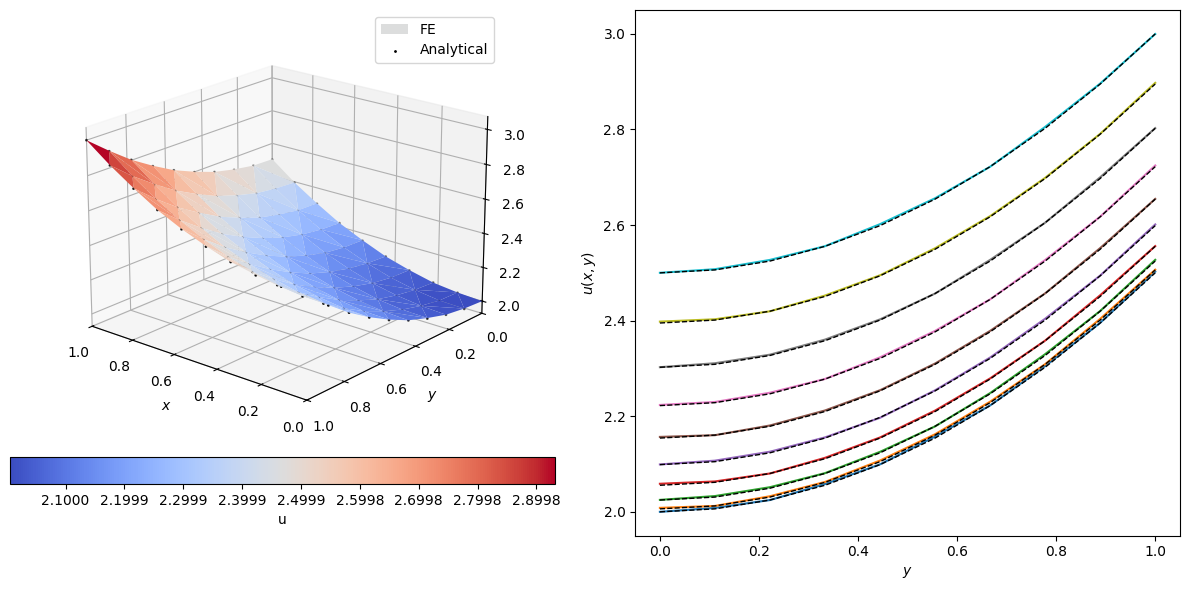

In [11]:
# Plot FE and analytical solution
from FEM_plot import plot3d
plt.rcParams['figure.figsize'] = 12, 6

# Analytical solution
x = mesh.tri.points[:, 0]
y = mesh.tri.points[:, 1]

u_exact_tmp = u_exact.reshape((n_x, n_y))
u_tmp = u.reshape((n_x, n_y))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
var = u.flatten()
plot3d(ax, u.flatten(), varmin=var.min(), varmax=var.max(), x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])
ax.scatter(x, y, u_exact, marker='o', c='black', s=1, label="Analytical")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y[:n_y], u_tmp)
plt.plot(y[:n_y], u_exact_tmp, color='k', ls='--', lw=1)
# plt.ylim([0, 1.01])
plt.xlabel(r'$y$')
plt.ylabel(r'$u(x,y)$')

plt.tight_layout()
plt.show()

In [12]:
# FEM solution
from FEM_poisson2d import Mesh, FEPoisson2D
mpl.rcParams['figure.figsize'] = 6, 6

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        return 2 * np.sin(_x) * np.sin(_y) 

    # Domain space
    x_min, x_max, n_x = 0, np.pi/2, 100
    y_min, y_max, n_y = 0, np.pi/2, 100

    """ 
    Create a rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 0
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        if p[0] == 0 and p[1] == 0:
            mesh.bc_points["dirichlet"][point_index] = u00

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == 0 and p2[0] == 0:  # x = 0, West
            mesh.bc_points["neumann_edge"][ch_idx] = [-np.sin(p1[1]), -np.sin(p2[1])]
        elif p1[0] == np.pi/2 and p2[0] == np.pi/2:  # x = 1, East
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == 0 and p2[1] == 0:  # y = 0, South
            mesh.bc_points["neumann_edge"][ch_idx] = [-np.sin(p1[0]), -np.sin(p2[0])]
        elif p1[1] == np.pi/2 and p2[1] == np.pi/2:  # y = 1, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D Poisson problem 
    """
    # Set a simulation object
    poisson = FEPoisson2D(mesh, RHS, _gpu=True, _sparse=True)
    # Process - build A and b
    poisson.process()
    # Solve for u = A^-1 b
    poisson.solve()
    # Get the result
    u = poisson.u

    """ 
    Plot FE and analytical solution 
    """
    # Analytical solution
    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    u_exact = np.sin(x) * np.sin(y) + u00
    # print(np.abs(u_exact - u.flatten()))

The mesh has 396 boundary nodes, and 9604 internal nodes
Solving using GPU
Solving sparse matrix


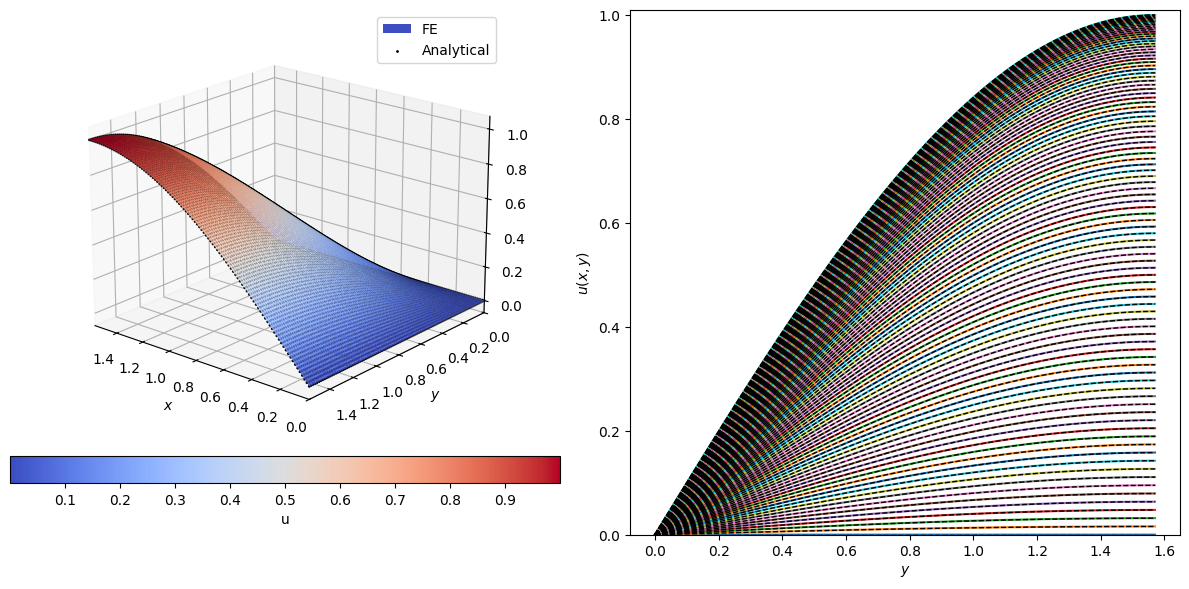

In [13]:
# Plot FE and analytical solution
from FEM_plot import plot3d
plt.rcParams['figure.figsize'] = 12, 6

# Analytical solution
x = mesh.tri.points[:, 0]
y = mesh.tri.points[:, 1]
# u_exact = x

u_exact_tmp = u_exact.reshape((n_x, n_y))
u_tmp = u.reshape((n_x, n_y))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])
ax.scatter(x, y, u_exact, marker='o', c='black', s=1, label="Analytical")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y[:n_y], u_tmp)
plt.plot(y[:n_y], u_exact_tmp, color='k', ls='--', lw=1)
plt.ylim([0, 1.01])
plt.xlabel(r'$y$')
plt.ylabel(r'$u(x,y)$')

plt.tight_layout()
plt.show()

# FEM 2D: $\frac{\partial u}{\partial t} = \frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} + f(x, y)$

## FEM solution fixed temperature at two sides

In [86]:
# FEM solution fixed temperature at two sides
from FEM_heat2d import Mesh, FEheat2D

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        return 0.0

    # Domain space
    iteration_max = 100
    x_min, x_max, n_x = -0.5, 0.5, 50
    y_min, y_max, n_y = -0.5, 0.5, 50

    """ 
    Create a rectangular mesh
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 1.0
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        if p[0] == x_min:  # x = x_min, West
            mesh.bc_points["dirichlet"][point_index] = 0.0
        if p[0] == x_max:  # x = x_max, East
            mesh.bc_points["dirichlet"][point_index] = 1.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        # if p1[0] == x_min and p2[0] == x_min:  # x = x_min, West
            # mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        # if p1[0] == x_max and p2[0] == x_max:  # x = x_max, East
            # mesh.bc_points["neumann_edge"][ch_idx] = [0.0, 0.0]
        if p1[1] == y_min and p2[1] == y_min:  # y = y_min, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == y_max and p2[1] == y_max:  # y = y_max, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem 
    """
    # Set a simulation object
    heat = FEheat2D(mesh, RHS, _gpu=True, _sparse=True)
    # Process - build A and b
    heat.initialze()
    # Solve for u = A^-1 b

    print('iteration=')
    for i in range(iteration_max):
        heat.solve()
        print(i, end=' ', flush=True)
    
    # Get the result
    u = heat.u

The mesh has 196 boundary nodes, and 2304 internal nodes
Solving using GPU: True
Solving using sparse matrix: True
iteration=
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

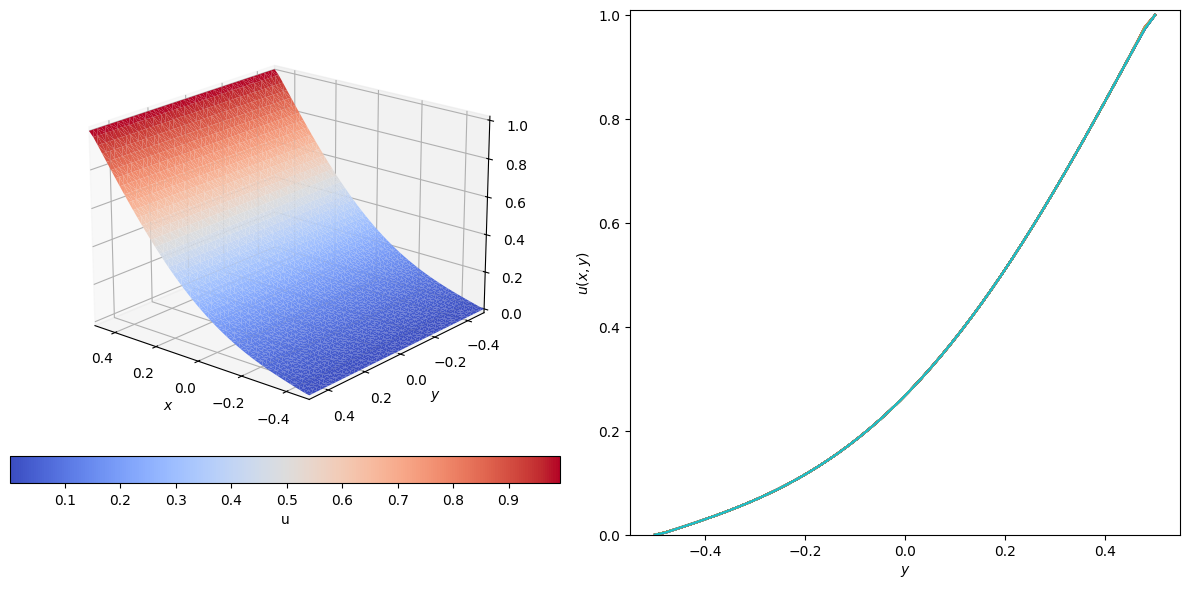

In [87]:
# Plot FE and analytical solution
from FEM_plot import plot3d
plt.rcParams['figure.figsize'] = 12, 6

# Analytical solution
x = mesh.tri.points[:, 0]
y = mesh.tri.points[:, 1]
u_exact = x

u_exact_tmp = u_exact.reshape((n_x, n_y))
u_tmp = u.reshape((n_x, n_y))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])

plt.subplot(1, 2, 2)
plt.plot(y[:n_y], u_tmp)
plt.ylim([0, 1.01])
plt.xlabel(r'$y$')
plt.ylabel(r'$u(x,y)$')

plt.tight_layout()
plt.show()

## FEM solution gaussian pulse initial condition

In [82]:
# FEM solution gaussian pulse initial condition
from FEM_heat2d import Mesh, FEheat2D

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        if _x**2 + _y**2 < 0.1:
            return 0.0
        else:
            return 0.0

    # Domain space
    iteration_max = 10
    x_min, x_max, n_x = -0.5, 0.5, 50
    y_min, y_max, n_y = -0.5, 0.5, 50

    """ 
    Create a rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    n_points = mesh.tri.npoints
    
    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 1.0
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        # if p[0] == x_min:  # x = x_min, West
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[0] == x_max:  # x = x_max, East
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_min:  # y = y_min, South
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_max:  # y = y_max, North
        #     mesh.bc_points["dirichlet"][point_index] = 0.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == x_min and p2[0] == x_min:  # x = x_min, West
            mesh.bc_points["neumann_edge"][ch_idx] = [0.0, 0.0]
        elif p1[0] == x_max and p2[0] == x_max:  # x = x_max, East
            mesh.bc_points["neumann_edge"][ch_idx] = [0.0, 0.0]
        if p1[1] == y_min and p2[1] == y_min:  # y = y_min, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == y_max and p2[1] == y_max:  # y = y_max, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem
    """
    # Initialze
    u0 = np.zeros((n_points, 1))
    u0[:, 0] = np.exp(-(x**2 + y**2)/(2.0 * 0.15**2))
    
    heat = FEheat2D(_mesh=mesh, _f=RHS, _u=u0, _gpu=True, _sparse=True)
    
    heat.initialze()
    
    # Solve for u = A^-1 b
    print('iteration=')
    for i in range(iteration_max):
        heat.solve()
        print(i, end=' ', flush=True)
    
    # Get the result
    u = heat.u

The mesh has 196 boundary nodes, and 2304 internal nodes
Solving using GPU: True
Solving using sparse matrix: True
iteration=
0 1 2 3 4 5 6 7 8 9 

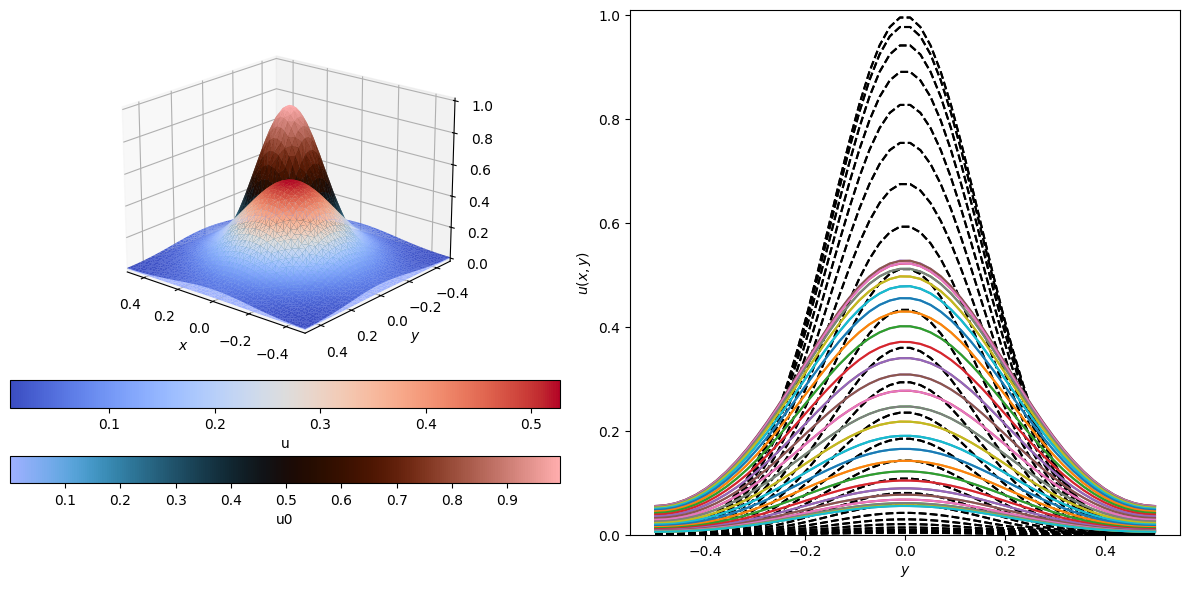

In [83]:
# Plot FE and analytical solution
from FEM_plot import plot3d
plt.rcParams['figure.figsize'] = 12, 6

u_tmp = u.reshape((n_x, n_y))
u0_tmp = u0.reshape((n_x, n_y))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, u0.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1], label=r'u0', cmap=cm.berlin)
plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])

plt.subplot(1, 2, 2)
plt.plot(y[:n_y], u0_tmp, color='k', ls='--')
plt.plot(y[:n_y], u_tmp)
plt.ylim([0, 1.01])
plt.xlabel(r'$y$')
plt.ylabel(r'$u(x,y)$')
plt.tight_layout()
plt.show()

## FEM solution heat source in the middle

In [80]:
# FEM solution heat source in the middle
from FEM_heat2d import Mesh, FEheat2D

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        if _x**2 + _y**2 < 0.1:
            return 10.0
        else:
            return 0.0

    # Domain space
    iteration_max = 100
    x_min, x_max, n_x = -0.5, 0.5, 20
    y_min, y_max, n_y = -0.5, 0.5, 20

    """ 
    Create a rectangular mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    n_points = mesh.tri.npoints
    
    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    u00 = 1.0
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        # if p[0] == x_min:  # x = x_min, West
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[0] == x_max:  # x = x_max, East
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_min:  # y = y_min, South
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_max:  # y = y_max, North
        #     mesh.bc_points["dirichlet"][point_index] = 0.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == x_min and p2[0] == x_min:  # x = x_min, West
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[0] == x_max and p2[0] == x_max:  # x = x_max, East
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        if p1[1] == y_min and p2[1] == y_min:  # y = y_min, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == y_max and p2[1] == y_max:  # y = y_max, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem
    """
    # Initialze
    u0 = np.zeros((n_points, 1))
    u0[:, 0] = np.exp(-(x**2 + y**2)/(2.0 * 0.15**2))
    
    heat = FEheat2D(_mesh=mesh, _f=RHS, _u=u0, _gpu=True, _sparse=True)
    
    heat.initialze()
    
    # Solve for u = A^-1 b
    print('iteration=')
    for i in range(iteration_max):
        heat.solve()
        print(i, end=' ', flush=True)
    
    # Get the result
    u = heat.u

The mesh has 76 boundary nodes, and 324 internal nodes
Solving using GPU: True
Solving using sparse matrix: True
iteration=
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

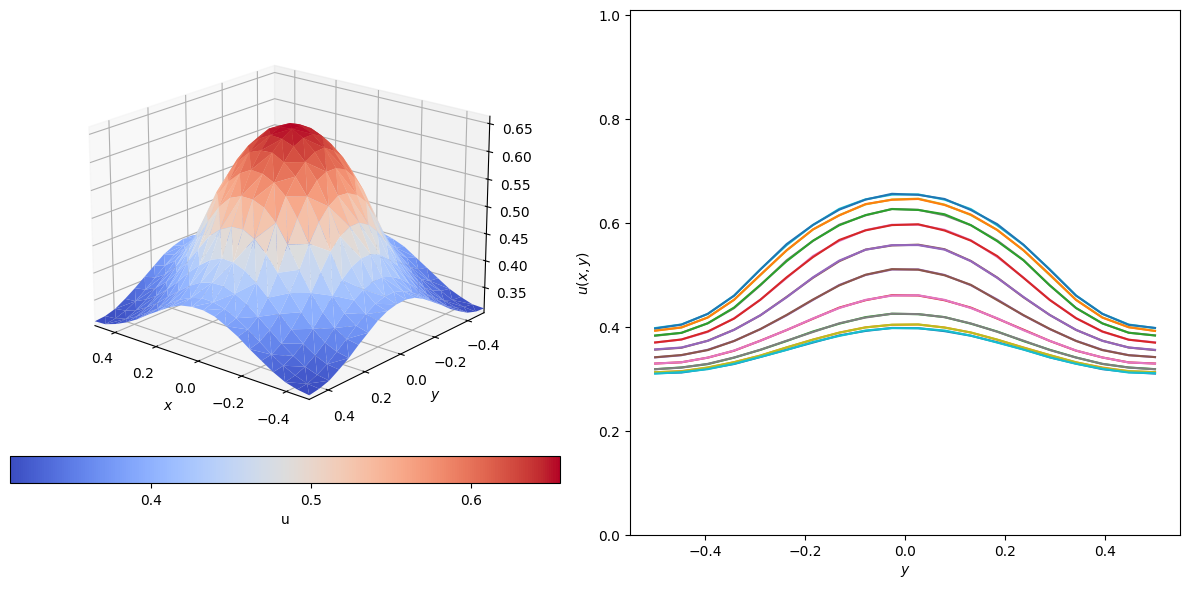

In [81]:
# Plot FE and analytical solution 
from FEM_plot import plot3d
plt.rcParams['figure.figsize'] = 12, 6

u_tmp = u.reshape((n_x, n_y))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])

plt.subplot(1, 2, 2)
plt.plot(y[:n_y], u_tmp)
plt.ylim([0, 1.01])
plt.xlabel(r'$y$')
plt.ylabel(r'$u(x,y)$')
plt.tight_layout()
plt.show()

## FEM solution Circular plate with heat source in the middle 

In [79]:
# FEM solution heat source in the middle (circle)
from FEM_heat2d import Mesh, FEheat2D
from FEM_plot import plot3d
mpl.rcParams['figure.figsize'] = 6, 6
plot = False
iteration_max = 100

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        if _x**2 + _y**2 < 0.1**2:
            return 10.0
        else:
            return 0.0

    """
    Domain space
    """
    x_min, x_max, n_x = -0.5, 0.5, 50
    y_min, y_max, n_y = -0.5, 0.5, 50

    """ 
    Create a mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y, rout=0.5)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    n_points = mesh.tri.npoints
    
    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    for point_index in mesh.boundary_points:
        p = mesh.tri.points[point_index]
        # if p[0] == x_min:  # x = x_min, West
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[0] == x_max:  # x = x_max, East
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_min:  # y = y_min, South
        #     mesh.bc_points["dirichlet"][point_index] = 0.0
        # if p[1] == y_max:  # y = y_max, North
        #     mesh.bc_points["dirichlet"][point_index] = 0.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        p1, p2 = mesh.tri.points[edge_points]
        mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem
    """
    # Initialze
    u0 = np.zeros((n_points, 1))
    u0[:, 0] = np.exp(-(x**2 + y**2)/(2.0 * 0.15**2))
    
    heat = FEheat2D(_mesh=mesh, _f=RHS, _u=u0, _gpu=True, _sparse=True)
    
    heat.initialze()

    # Solve for u = A^-1 b
    print('iteration=')
    for i in range(iteration_max):
        heat.solve()
        print(i, end=' ', flush=True)
    
        # Get the result
        u = heat.u

        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1, projection='3d')
            plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])
            
            plt.tight_layout()
            plt.show()

The mesh has 96 boundary nodes, and 1780 internal nodes
Solving using GPU: True
Solving using sparse matrix: True
iteration=
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

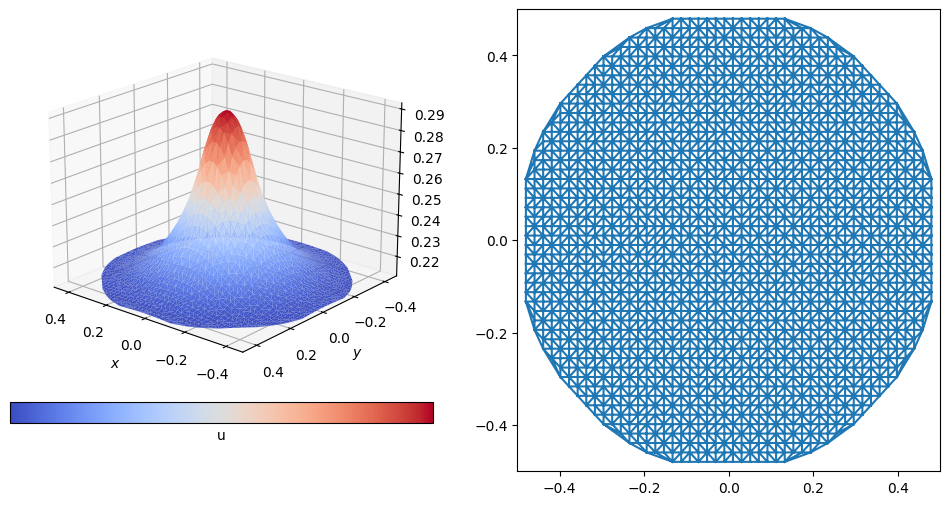

<Figure size 1200x600 with 0 Axes>

In [77]:
mpl.rcParams['figure.figsize'] = 12, 6

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])

plt.subplot(1, 2, 2)
plt.triplot(mesh.tri.points[:,0], mesh.tri.points[:,1], mesh.tri.simplices)
# plt.plot(mesh.tri.points[:,0], mesh.tri.points[:,1], 'o')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

plt.tight_layout()
# plt.savefig('u.pdf', format='pdf')
plt.show()

# FEM 2D: $\frac{\partial u}{\partial t} = \frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} + f(x, y)$, cavity in the middle

## Delaunay

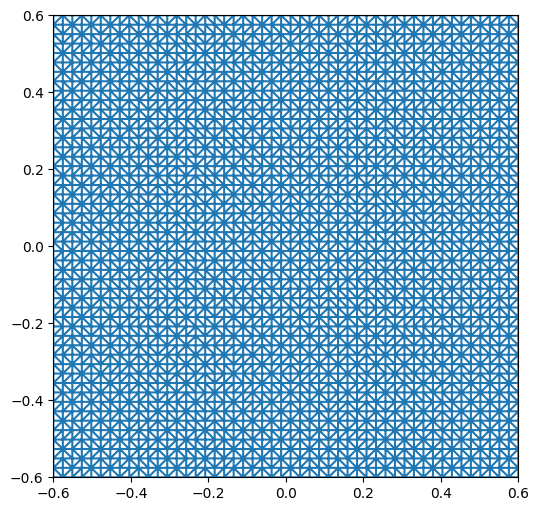

In [42]:
# points
x_min, x_max, n_x = -0.6, 0.6, 50
y_min, y_max, n_y = -0.6, 0.6, 50
r = 0.5

points = []
nodes_x = np.linspace(x_min, x_max, n_x)
nodes_y = np.linspace(y_min, y_max, n_y)
for x in nodes_x:
    for y in nodes_y:
        points.append([x, y])
        
points = np.array(points)

# triangle
tri = sp.spatial.Delaunay(points)
boundary_points = np.unique(tri.convex_hull.flatten())
# print(boundary_points)
# print(np.sqrt((tri.points[boundary_points]**2).sum(axis=1))/r)

# plot
mpl.rcParams['figure.figsize'] = 6, 6
plt.triplot(points[:,0], points[:,1], tri.simplices)
# plt.plot(points[:,0], points[:,1], 'o')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

(225,)
(225,) (2500,)


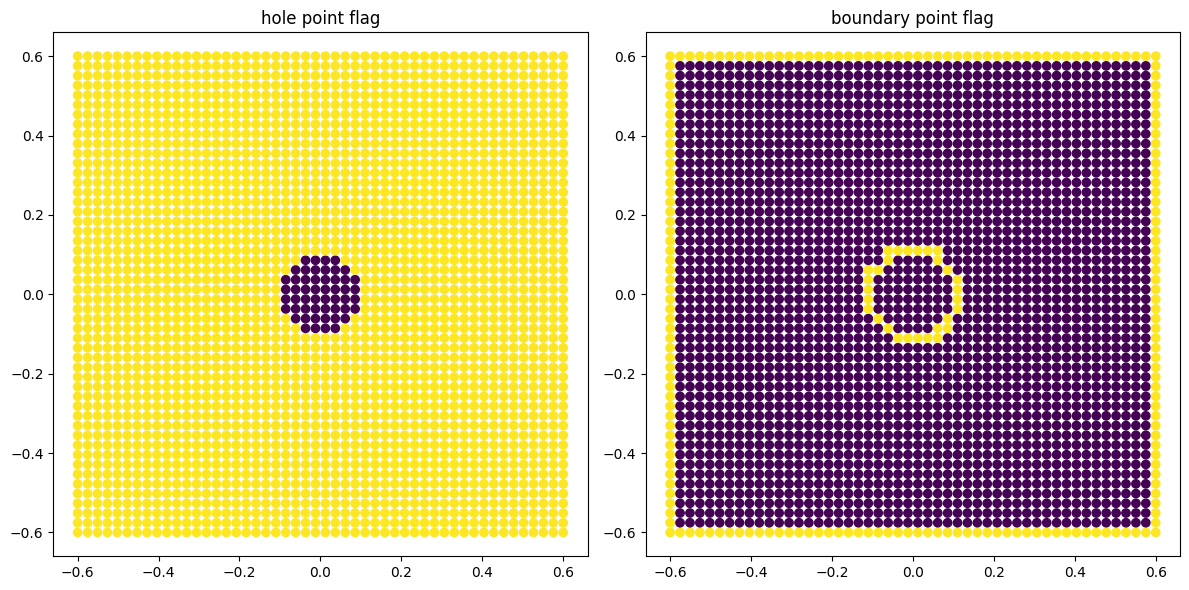

In [45]:
r2 = 0.1**2

pflg = np.ones(tri.npoints, dtype=bool)
sflg = np.ones(tri.nsimplex, dtype=bool)
bflg = np.zeros(tri.npoints, dtype=bool)

for idx, p in enumerate(tri.points):
    if (p**2).sum() < r2:
        pflg[idx] = False

print(boundary_points.shape)

for idx, p_idx in enumerate(tri.simplices):
    if not pflg[p_idx[0]] or not pflg[p_idx[1]] or not pflg[p_idx[2]]:
        sflg[idx] = False
        p1, p2, p3 = (tri.points[p_idx[0]], tri.points[p_idx[1]], tri.points[p_idx[2]])
        if (p1**2).sum() >= r2:
            bflg[p_idx[0]] = True
            boundary_points = np.append(boundary_points, p_idx[0]*np.ones(1, dtype=int))
        if (p2**2).sum() >= r2:
            bflg[p_idx[1]] = True
            boundary_points = np.append(boundary_points, p_idx[1]*np.ones(1, dtype=int))
        if (p3**2).sum() >= r2:
            bflg[p_idx[2]] = True
            boundary_points = np.append(boundary_points, p_idx[2]*np.ones(1, dtype=int))

boundary_points = np.unique(boundary_points)
print(boundary_points.shape, bflg.shape)

for p_idx in boundary_points:
    bflg[p_idx] = True 


mpl.rcParams['figure.figsize'] = 12, 6
plt.subplot(1, 2, 1)
plt.scatter(x=points[:, 0], y=points[:, 1], c=pflg)
plt.title('hole point flag')
plt.subplot(1, 2, 2)
plt.scatter(x=points[:, 0], y=points[:, 1], c=bflg)
plt.title('boundary point flag')
plt.tight_layout()
plt.show()

## FEM solution square plate with cavity in the middle

In [92]:
# FEM solution cavity in the middle
from FEM_heat2d_cavity import Mesh, FEheat2D
from FEM_plot import plot3d
mpl.rcParams['figure.figsize'] = 6, 6
plot = False
iteration_max = 100

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        return 0.0

    """
    Domain space
    """
    x_min, x_max, n_x = -0.5, 0.5, 50
    y_min, y_max, n_y = -0.5, 0.5, 50

    """ 
    Create a mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y, r=0.1)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    n_points = mesh.npoints

    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    for point_index in mesh.boundary_points:
        if mesh.cbflg[point_index]:  # cavity boundary
            mesh.bc_points["dirichlet"][point_index] = 1.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        if mesh.cbflg[p1_idx] or mesh.cbflg[p2_idx]:
            print(mesh.cbflg[p1_idx], mesh.cbflg[p2_idx], end=', ')
        p1, p2 = mesh.tri.points[edge_points]
        if p1[0] == x_min and p2[0] == x_min:  # x = x_min, West
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[0] == x_max and p2[0] == x_max:  # x = x_max, East
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == y_min and p2[1] == y_min:  # y = y_min, South
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]
        elif p1[1] == y_max and p2[1] == y_max:  # y = y_max, North
            mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem
    """
    # Initialze
    u0 = np.zeros((n_points, 1))
    
    heat = FEheat2D(_mesh=mesh, _f=RHS, _u=u0, _gpu=True, _sparse=True)
    
    heat.initialze()

    # Solve for u = A^-1 b
    print('iteration=')
    for i in range(iteration_max):
        print(i, end=' ')
        
        heat.solve()
    
        # Get the result
        u = np.array([[heat.u[mesh.pmap[i]] if mesh.pmap[i] > -1 else np.ones(1)] for i in range(mesh.tri.npoints)]).reshape(mesh.tri.npoints)

        # plot
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1, projection='3d')
            plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])
            plt.tight_layout()
            plt.show()

# cavity points= 76
# non-cavity points= 2424
# boundary points excluding cavity= 196
# boundary points including cavity= 229
The mesh has 229 boundary nodes, and 2271 internal nodes
Solving using GPU: True
Solving using sparse matrix: True
iteration=
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

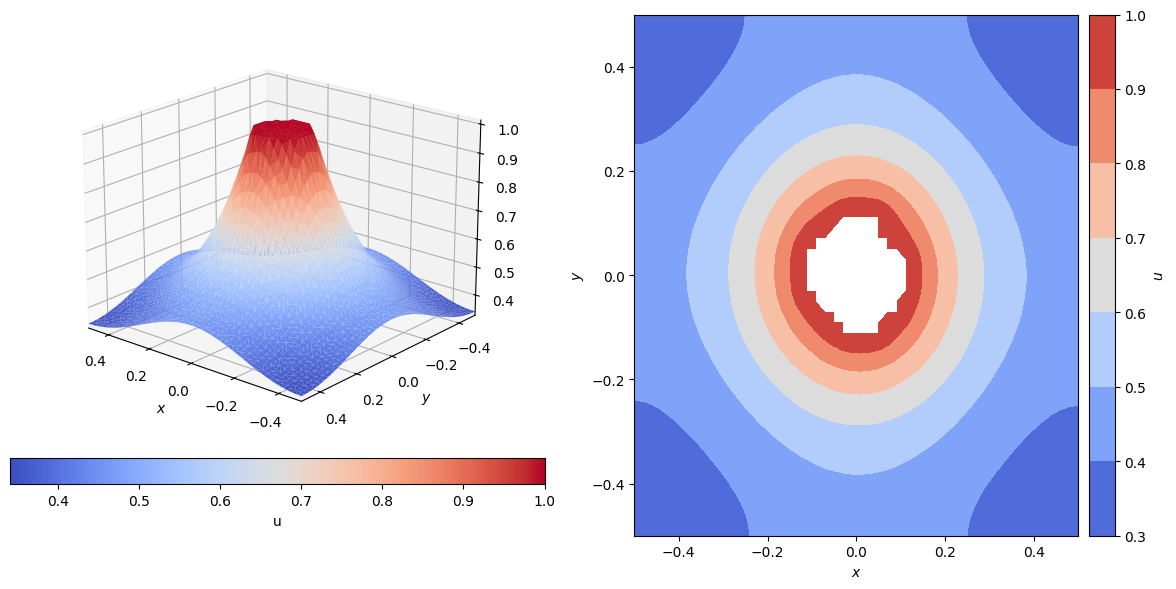

In [93]:
# plot
mpl.rcParams['figure.figsize'] = 12, 6
# plt.ion()

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, u, varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])

ax = fig.add_subplot(1, 2, 2)
surf = ax.tricontourf(x, y, u, cmap=cm.coolwarm)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(surf, ax=ax, orientation="vertical", pad=0.02, ticks=np.linspace(0, 1, 11))
cbar.ax.set_ylabel(r'$u$')

plt.tight_layout()
# plt.savefig('u.pdf', format='pdf')
plt.show()

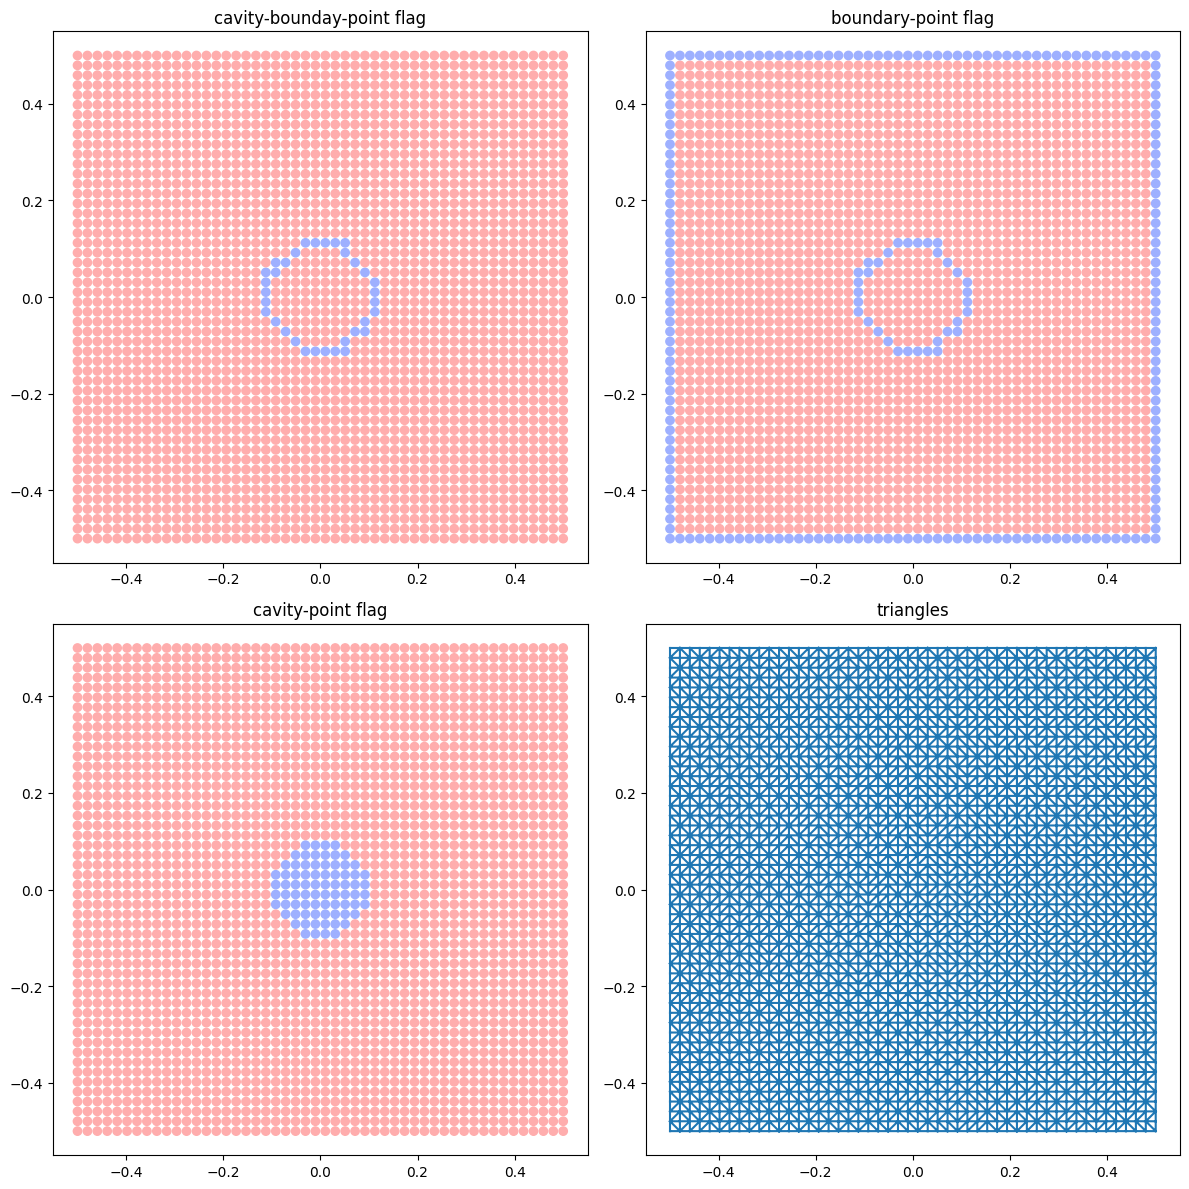

In [94]:
# plot geometry
mpl.rcParams['figure.figsize'] = 12, 12
plt.subplot(2, 2, 1)
plt.scatter(x=x, y=y, c=mesh.cbflg, cmap=cm.berlin_r)
plt.title('cavity-bounday-point flag')
plt.subplot(2, 2, 2)
plt.scatter(x=x, y=y, c=mesh.bflg, cmap=cm.berlin_r)
plt.title('boundary-point flag')
plt.subplot(2, 2, 3)
plt.scatter(x=x, y=y, c=~mesh.pflg, cmap=cm.berlin_r)
plt.title('cavity-point flag')
plt.subplot(2, 2, 4)
plt.triplot(mesh.tri.points[:,0], mesh.tri.points[:,1], mesh.tri.simplices)
plt.title('triangles')
plt.tight_layout()
plt.show()

## FEM solution circular plate with cavity in the middle

In [96]:
# FEM solution cavity in the middle
from FEM_heat2d_cavity import Mesh, FEheat2D
from FEM_plot import plot3d
mpl.rcParams['figure.figsize'] = 6, 6
plot = False
iteration_max = 100

if __name__ == '__main__':
    """
    Problem setup
    """
    # Right-hand side function
    def RHS(_x, _y):
        return 0.0

    """
    Domain space
    """
    x_min, x_max, n_x = -0.5, 0.5, 50
    y_min, y_max, n_y = -0.5, 0.5, 50

    """ 
    Create a mesh 
    """
    # Create a mesh object with Delaunay mesh and a 
    #    boundary condition dictionary
    mesh = Mesh(x_min, x_max, n_x, y_min, y_max, n_y, r=0.1, rout=0.5)
    # Mesh data
    inner_points = [i for i in range(len(mesh.tri.points))
                    if i not in mesh.boundary_points]
    print("The mesh has {} boundary nodes, and {} internal nodes".format(
        len(mesh.boundary_points), len(inner_points)))

    x = mesh.tri.points[:, 0]
    y = mesh.tri.points[:, 1]
    n_points = mesh.npoints

    """ 
    Set boundary conditions 
    """
    # Set the Dirichlet boundary conditions
    for point_index in mesh.boundary_points:
        if mesh.cbflg[point_index]:  # cavity boundary
            mesh.bc_points["dirichlet"][point_index] = 1.0

    # Set the Neumann boundary conditions
    for ch_idx, edge_points in enumerate(mesh.tri.convex_hull):
        p1_idx, p2_idx = edge_points
        if mesh.cbflg[p1_idx] or mesh.cbflg[p2_idx]:
            print(mesh.cbflg[p1_idx], mesh.cbflg[p2_idx], end=', ')
        p1, p2 = mesh.tri.points[edge_points]
        mesh.bc_points["neumann_edge"][ch_idx] = [0, 0]

    """ 
    Solve the 2D heat problem
    """
    # Initialze
    u0 = np.zeros((n_points, 1))
    
    heat = FEheat2D(_mesh=mesh, _f=RHS, _u=u0, _gpu=True, _sparse=True)
    
    heat.initialze()

    # Solve for u = A^-1 b
    print('iteration=')
    for i in range(iteration_max):
        print(i, end=' ', flush=True)
        
        heat.solve()
    
        # Get the result
        u = np.array([[heat.u[mesh.pmap[i]] if mesh.pmap[i] > -1 else np.ones(1)] for i in range(mesh.tri.npoints)]).reshape(mesh.tri.npoints)

        # plot
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1, projection='3d')
            plot3d(ax, u.flatten(), varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])
            plt.tight_layout()
            plt.show()

# cavity points= 76
# non-cavity points= 1800
# boundary points excluding cavity= 96
# boundary points including cavity= 131
The mesh has 131 boundary nodes, and 1745 internal nodes
Solving using GPU: True
Solving using sparse matrix: True
iteration=
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

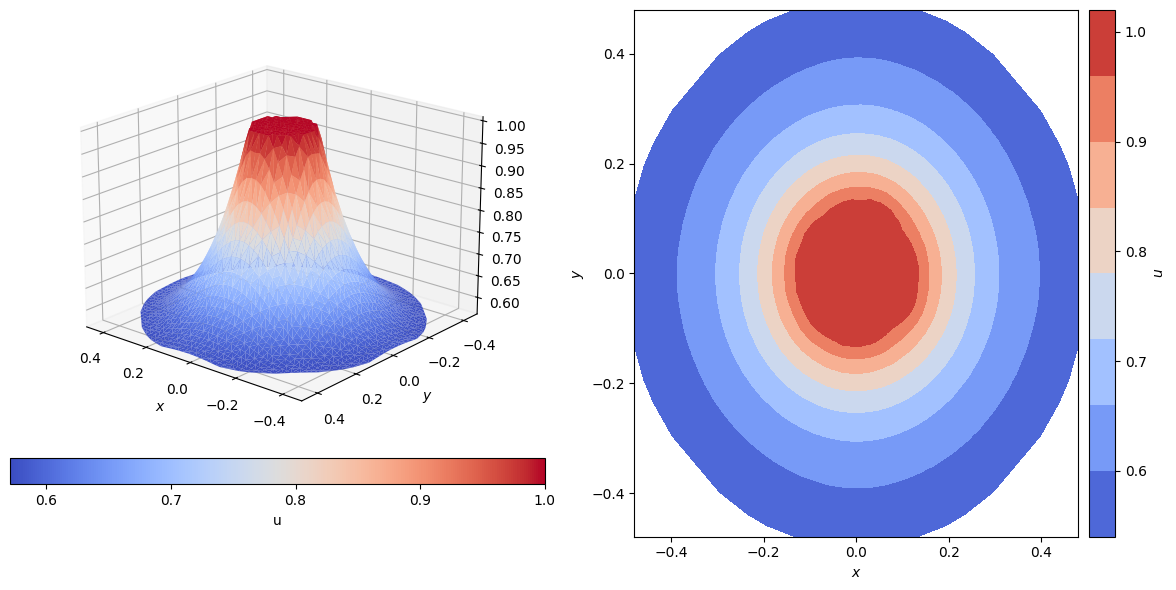

In [97]:
# plot
mpl.rcParams['figure.figsize'] = 12, 6
# plt.ion()

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, u, varmin=0, varmax=1, x=mesh.tri.points[:, 0], y=mesh.tri.points[:, 1])

ax = fig.add_subplot(1, 2, 2)
surf = ax.tricontourf(x, y, u, cmap=cm.coolwarm)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
cbar = plt.colorbar(surf, ax=ax, orientation="vertical", pad=0.02, ticks=np.linspace(0, 1, 11))
cbar.ax.set_ylabel(r'$u$')

plt.tight_layout()
# plt.savefig('u.pdf', format='pdf')
plt.show()

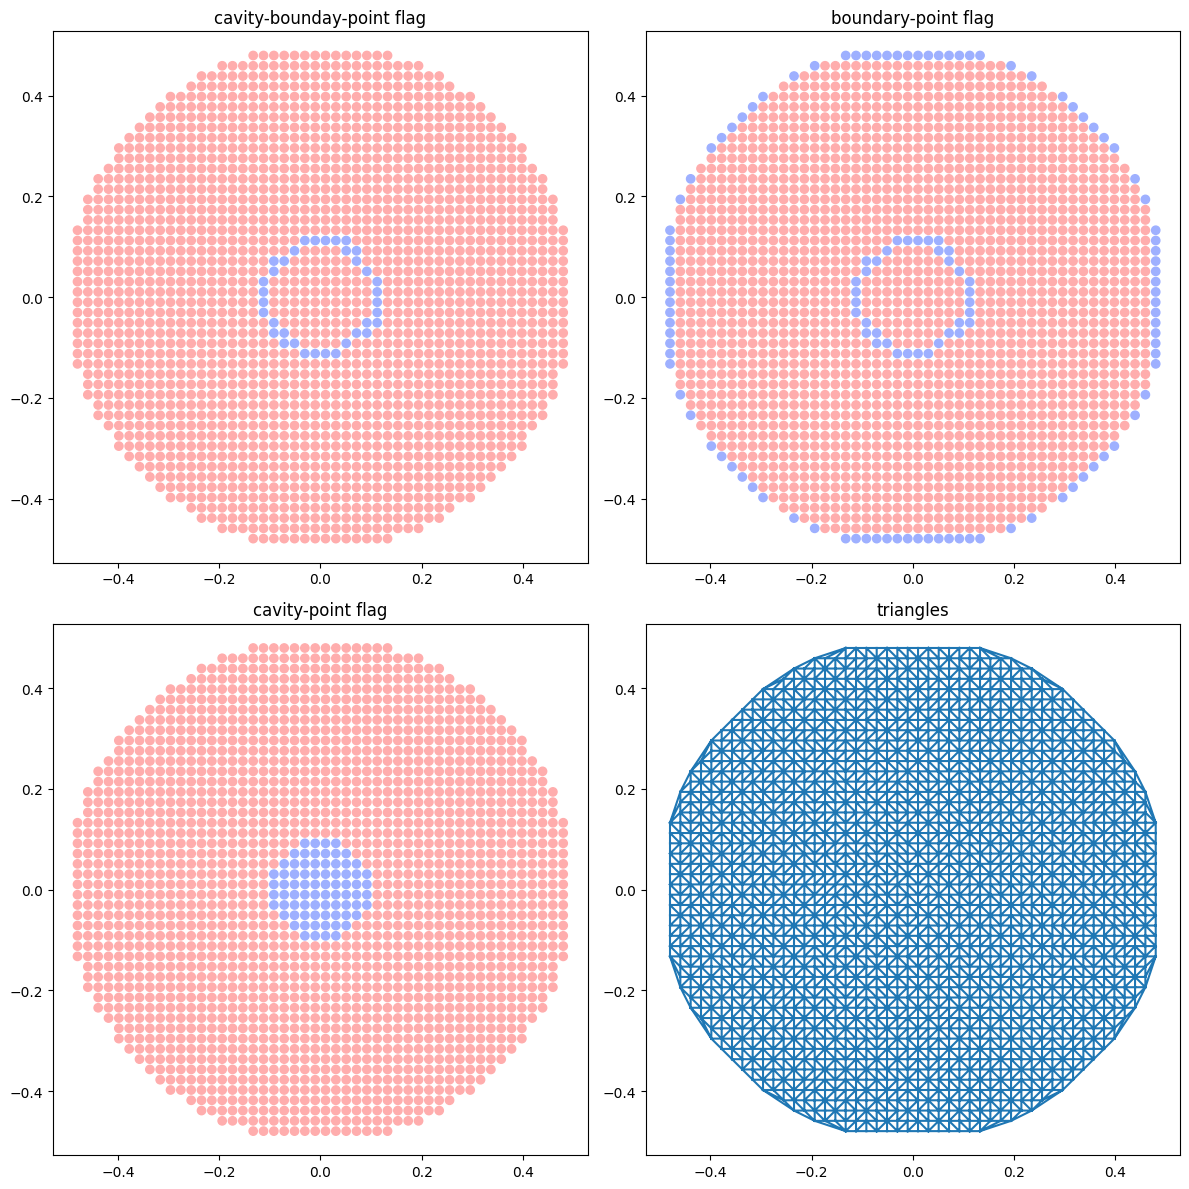

In [98]:
# plot geometry
mpl.rcParams['figure.figsize'] = 12, 12
plt.subplot(2, 2, 1)
plt.scatter(x=x, y=y, c=mesh.cbflg, cmap=cm.berlin_r)
plt.title('cavity-bounday-point flag')
plt.subplot(2, 2, 2)
plt.scatter(x=x, y=y, c=mesh.bflg, cmap=cm.berlin_r)
plt.title('boundary-point flag')
plt.subplot(2, 2, 3)
plt.scatter(x=x, y=y, c=~mesh.pflg, cmap=cm.berlin_r)
plt.title('cavity-point flag')
plt.subplot(2, 2, 4)
plt.triplot(mesh.tri.points[:,0], mesh.tri.points[:,1], mesh.tri.simplices)
plt.title('triangles')
plt.tight_layout()
plt.show()